# **Method**

1. Define Lady Elliot Bounding Box (spatial and temporal range of this study) 

2. Extract eReefs hydrodynamic variables for Lady Elliot Island Bounding Box

3. Compute variable seasonality (monthly trends)

4. Compare seasonal trends between variables

5. Calculate statistics for monthly and annual variable trends

**Setup**

Load dependencies

In [1]:
import os
import scipy
import numpy as np
import pandas as pd

import io
import requests

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import cmocean

import seaborn as sns
import pymannkendall as mk

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,7)
%matplotlib inline

In [2]:
# Define base directory
base_dir = "VariableLooping_Outputs"

# Define subfolders
folders = {
    "data": os.path.join(base_dir, "data"),
    "plots": os.path.join(base_dir, "plots"),
}

# Define nested folders 
heatmaps_folder = os.path.join(folders["plots"], "heat_maps")
os.makedirs(heatmaps_folder, exist_ok=True)

timeseries_folder = os.path.join(folders["plots"], "timeseries")
os.makedirs(timeseries_folder, exist_ok=True)

distributions_folder = os.path.join(folders["plots"], "distributions")
os.makedirs(distributions_folder, exist_ok=True)

# Create all folders
for path in folders.values():
    os.makedirs(path, exist_ok=True)

Define "find_nearest" function to be able to find index of nearest value in a numpy array

In [3]:
def find_nearest(array, value):
    '''
    Find index of nearest value in a numpy array
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

# Step 1 - Define Bounding Box

Set Lady Elliot Island Coordinates 

In [4]:
site_lat = -24.11
site_lon = 152.71

Set Depth

In [5]:
selectedDepthIndex = 16 # corresponding to -0.5 m

Set Timeframe

In [6]:
# Define starting and ending date of the netcdf file we want to load 
start_date = dt.date(2011, 1, 1)
end_date = dt.date(2013, 12, 31)
delta = relativedelta(months=+1)

# Step 2 - Extract eReefs Data

Loop Through Each eReefs Variable

In [16]:
# Loop through each variable in thredds netcdf file and extract data for site and time of interest
step = True
while start_date <= end_date:
    
    # Read individual file from the OpeNDAP server
    netCDF_datestr = str(start_date.year)+'-'+format(start_date.month, '02')
    print('Processing time interval:',netCDF_datestr)
    inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"
    start_date += delta    
    nc_data = Dataset(inputFile, 'r')
    ncdata = nc_data.variables
    
    # Get parameters values for each single file
    if step:
        lat = ncdata['latitude'][:].filled(fill_value=0.)
        lon = ncdata['longitude'][:].filled(fill_value=0.)
        times = ncdata['time'][:]
        selectedLatIndex = find_nearest(lat,site_lat)
        selectedLonIndex = find_nearest(lon,site_lon)
        current = nc_data.variables['mean_cur'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        wind = nc_data.variables['mean_wspeed'][:, selectedLatIndex, selectedLonIndex]
        temperature = nc_data.variables['temp'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        salinity = nc_data.variables['salt'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        u = nc_data.variables['u'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        v = nc_data.variables['v'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
    else:
        days = ncdata['time'][:]
        times = np.hstack((times,days))
        dailyCurr = nc_data.variables['mean_cur'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        current = np.hstack((current,dailyCurr))
        dailyWind = nc_data.variables['mean_wspeed'][:, selectedLatIndex, selectedLonIndex]
        wind = np.hstack((wind,dailyWind))
        dailyTemp = nc_data.variables['temp'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        temperature = np.hstack((temperature,dailyTemp))
        dailySalt = nc_data.variables['salt'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        salinity = np.hstack((salinity,dailySalt))
        dailyU = nc_data.variables['u'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        u = np.hstack((u,dailyU))
        dailyV = nc_data.variables['v'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        v = np.hstack((v,dailyV))
    step = False

# Transform 'time' data into calendar dates
time = pd.to_datetime(times[:],unit='D',origin=pd.Timestamp('1990-01-01'))

# Create a pandas dataframe containing the information from all the files
df = pd.DataFrame(
    data={
        "date": time,
        "current": current,
        "wind": wind,
        "salinity": salinity,
        "temperature": temperature,
        "u": u,
        "v": v
    }
)

Processing time interval: 2011-01
Processing time interval: 2011-02
Processing time interval: 2011-03
Processing time interval: 2011-04
Processing time interval: 2011-05
Processing time interval: 2011-06
Processing time interval: 2011-07
Processing time interval: 2011-08
Processing time interval: 2011-09
Processing time interval: 2011-10
Processing time interval: 2011-11
Processing time interval: 2011-12
Processing time interval: 2012-01
Processing time interval: 2012-02
Processing time interval: 2012-03
Processing time interval: 2012-04
Processing time interval: 2012-05
Processing time interval: 2012-06
Processing time interval: 2012-07
Processing time interval: 2012-08
Processing time interval: 2012-09
Processing time interval: 2012-10
Processing time interval: 2012-11
Processing time interval: 2012-12
Processing time interval: 2013-01
Processing time interval: 2013-02
Processing time interval: 2013-03
Processing time interval: 2013-04
Processing time interval: 2013-05
Processing tim

NameError: name 'combined_df' is not defined

In [22]:
# Store pandas dataframe as a csv file so I don't need to rerun this cell
csv_path = os.path.join(folders["data"], "full_LadyElliot_eReefs_timeseries.csv")

df.to_csv(csv_path, index=False)

Call Dataframe to Jupyter Environment and Inspect

In [7]:
csv_path = os.path.join(folders["data"], "full_LadyElliot_eReefs_timeseries.csv")
df = pd.read_csv(
    csv_path,
    sep=",",          # use comma instead of whitespace
    engine="c",
    header=0,
    na_filter=False,
    low_memory=False
)

df['date']= pd.to_datetime(df['date'])

df

,date,current,wind,salinity,temperature,u,v
0,2011-01-01,0.411769,8.225824,35.281070,26.402613,-0.254784,-0.021583
1,2011-01-02,0.423713,6.587533,35.289307,26.393246,-0.096774,-0.055034
2,2011-01-03,0.455849,3.598129,35.301105,26.457840,-0.011286,-0.002039
3,2011-01-04,0.500103,4.478415,35.305530,26.492310,-0.011998,-0.022685
4,2011-01-05,0.495757,4.246986,35.315357,26.430445,-0.026243,-0.060517
...,...,...,...,...,...,...,...
1091,2013-12-27,0.323684,4.099777,35.486523,25.279936,0.142076,-0.106863
1092,2013-12-28,0.313979,3.600255,35.484505,25.398457,0.093029,-0.121631
1093,2013-12-29,0.381344,6.021391,35.484566,25.470165,0.138604,-0.137159
1094,2013-12-30,0.404526,4.195633,35.497093,25.502907,0.069412,-0.066357


# Step 3 - Compute Variable Seasonality

## **Calculate Monthly Trends**

Create Dataframe With 30-Day Rolling Averages

In [8]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

# Define rolling average for each variable 
current_roll = rolling["current"]
wind_roll = rolling["wind"]
salinity_roll = rolling["salinity"]
temperature_roll = rolling["temperature"]
u_roll = rolling["u"]
v_roll = rolling["v"]

# Store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "current": df['current'],
                "current_roll": current_roll,
                "wind": df['wind'],
                "wind_roll": wind_roll,
                "salinity": df['salinity'],
                "salinity_roll": salinity_roll,
                "temperature": df['temperature'],
                "temperature_roll": temperature_roll,
                "u": df['u'],
                "u_roll": u_roll,
                "v": df['v'],
                "v_roll": v_roll,
            }
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,current,current_roll,wind,wind_roll,salinity,salinity_roll,temperature,temperature_roll,u,u_roll,v,v_roll,day,month,year
0,2011-01-01,0.411769,0.411769,8.225824,8.225824,35.281070,35.281070,26.402613,26.402613,-0.254784,-0.254784,-0.021583,-0.021583,1,1,2011
1,2011-01-02,0.423713,0.417741,6.587533,7.406678,35.289307,35.285189,26.393246,26.397930,-0.096774,-0.175779,-0.055034,-0.038309,2,1,2011
2,2011-01-03,0.455849,0.430444,3.598129,6.137162,35.301105,35.290494,26.457840,26.417900,-0.011286,-0.120948,-0.002039,-0.026219,3,1,2011
3,2011-01-04,0.500103,0.447858,4.478415,5.722475,35.305530,35.294253,26.492310,26.436502,-0.011998,-0.093710,-0.022685,-0.025335,4,1,2011
4,2011-01-05,0.495757,0.457438,4.246986,5.427377,35.315357,35.298474,26.430445,26.435291,-0.026243,-0.080217,-0.060517,-0.032372,5,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2013-12-27,0.323684,0.366282,4.099777,6.602010,35.486523,35.566869,25.279936,24.934889,0.142076,0.016172,-0.106863,-0.043678,27,12,2013
1092,2013-12-28,0.313979,0.365511,3.600255,6.582251,35.484505,35.559118,25.398457,24.962432,0.093029,0.014605,-0.121631,-0.043518,28,12,2013
1093,2013-12-29,0.381344,0.364817,6.021391,6.556481,35.484566,35.551251,25.470165,24.994305,0.138604,0.012305,-0.137159,-0.043592,29,12,2013
1094,2013-12-30,0.404526,0.365392,4.195633,6.464545,35.497093,35.543510,25.502907,25.026736,0.069412,0.010409,-0.066357,-0.044734,30,12,2013


Plot timeseries for average conditions at Lady Elliot Island

*Current speed*

Min surface current: 0.169 m/s
Max surface current: 0.623 m/s
Mean surface current: 0.372 m/s
Median surface current: 0.369 m/s
SD surface current: 0.082 m/s
95th percentile current: 0.508 m/s


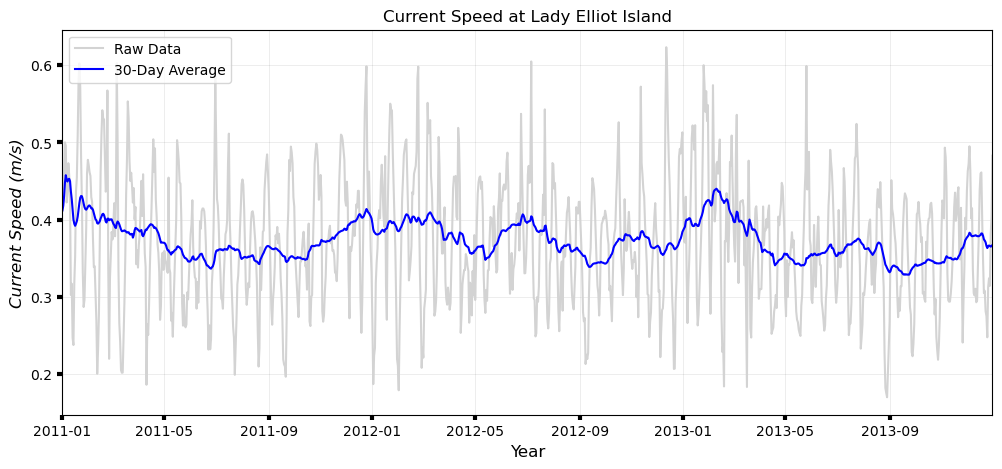

In [9]:
# Plot timeseries
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.current, color="lightgrey")
ax1.plot(
    timeseries.date,
    timeseries.current_roll,
    color="blue",
)
ax1.legend(
    labels=["Raw Data", str(days) + "-Day Average"],
    loc="upper left",
)

# Calculate dataset statistics
ax1.set_ylabel("Current Speed (m/s)", style="italic", fontsize=12)
print("Min surface current: {:0.3f} m/s".format(min(timeseries.current)))
print("Max surface current: {:0.3f} m/s".format(max(timeseries.current)))
print("Mean surface current: {:0.3f} m/s".format(np.mean(timeseries.current)))
print("Median surface current: {:0.3f} m/s".format(np.median(timeseries.current)))
print("SD surface current: {:0.3f} m/s".format(np.std(timeseries.current)))
print("95th percentile current: {:0.3f} m/s".format(np.percentile(timeseries.current, 95)))

# Format and Save Timeseries as Image
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.title("Current Speed at Lady Elliot Island")
plot_path = os.path.join(timeseries_folder, "LE_current_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

*Wind speed*

Min wind: 1.220 m/s
Max wind: 15.269 m/s
Mean wind: 6.974 m/s
Median wind: 6.720 m/s
SD wind: 2.657 m/s
95th percentile wind: 11.661 m/s


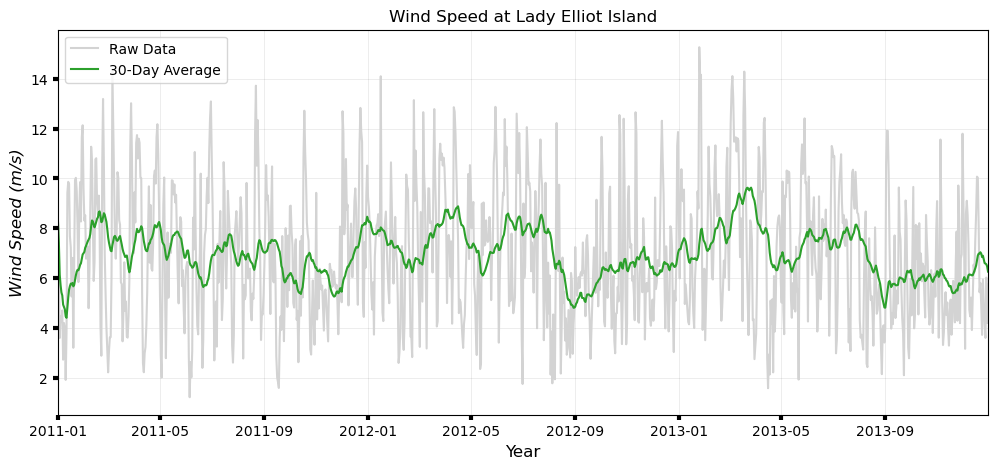

In [10]:
### WIND
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.wind, color="lightgrey")
ax1.plot(
    timeseries.date,
    timeseries.wind_roll,
    color="tab:green"
)
ax1.legend(
    labels=["Raw Data", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Wind Speed (m/s)", style="italic", fontsize=12)
print("Min wind: {:0.3f} m/s".format(min(timeseries.wind)))
print("Max wind: {:0.3f} m/s".format(max(timeseries.wind)))
print("Mean wind: {:0.3f} m/s".format(np.mean(timeseries.wind)))
print("Median wind: {:0.3f} m/s".format(np.median(timeseries.wind)))
print("SD wind: {:0.3f} m/s".format(np.std(timeseries.wind)))
print("95th percentile wind: {:0.3f} m/s".format(np.percentile(timeseries.wind, 95)))

ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.title("Wind Speed at Lady Elliot Island")
plot_path = os.path.join(timeseries_folder, "LE_wind_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

*Temperature*

Min surface temperature: 20.564 deg. C
Max surface temperature: 26.771 deg. C
Mean surface temperature: 23.798 deg. C
Median surface temperature: 23.662 deg. C
SD surface temperature: 1.637 deg. C
95th percentile surface temperature: 26.178 deg. C


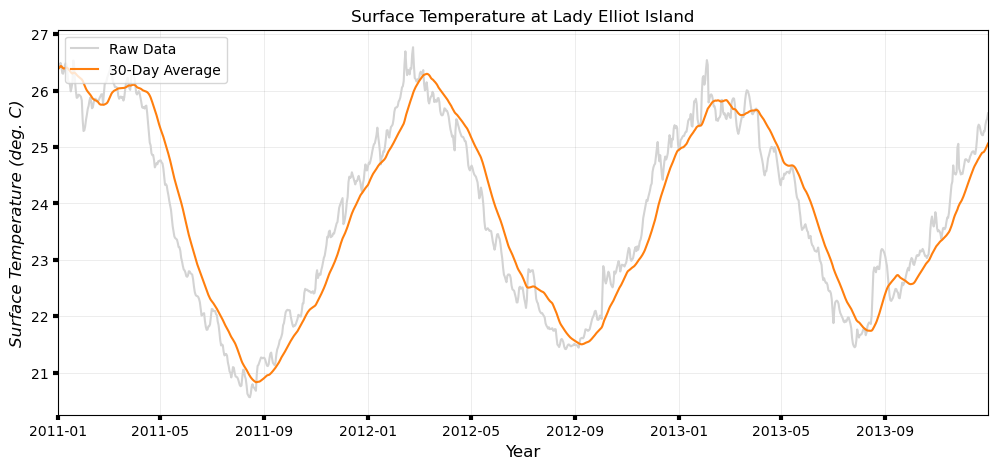

In [11]:
### TEMPERATURE
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.temperature, color="lightgrey")
ax1.plot(
    timeseries.date,
    timeseries.temperature_roll,
    color="tab:orange",
)
ax1.legend(
    labels=["Raw Data", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Surface Temperature (deg. C)", style="italic", fontsize=12)
print("Min surface temperature: {:0.3f} deg. C".format(min(timeseries.temperature)))
print("Max surface temperature: {:0.3f} deg. C".format(max(timeseries.temperature)))
print("Mean surface temperature: {:0.3f} deg. C".format(np.mean(timeseries.temperature)))
print("Median surface temperature: {:0.3f} deg. C".format(np.median(timeseries.temperature)))
print("SD surface temperature: {:0.3f} deg. C".format(np.std(timeseries.temperature)))
print("95th percentile surface temperature: {:0.3f} deg. C".format(np.percentile(timeseries.temperature, 95)))

ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.title("Surface Temperature at Lady Elliot Island")
plot_path = os.path.join(timeseries_folder, "LE_temperature_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

*Salinity*

Min surface salinity: 34.804 PSU
Max surface salinity: 35.834 PSU
Mean surface salinity: 35.428 PSU
Median surface salinity: 35.429 PSU
SD surface salinity: 0.199 PSU
95th percentile surface salinity: 35.758 PSU


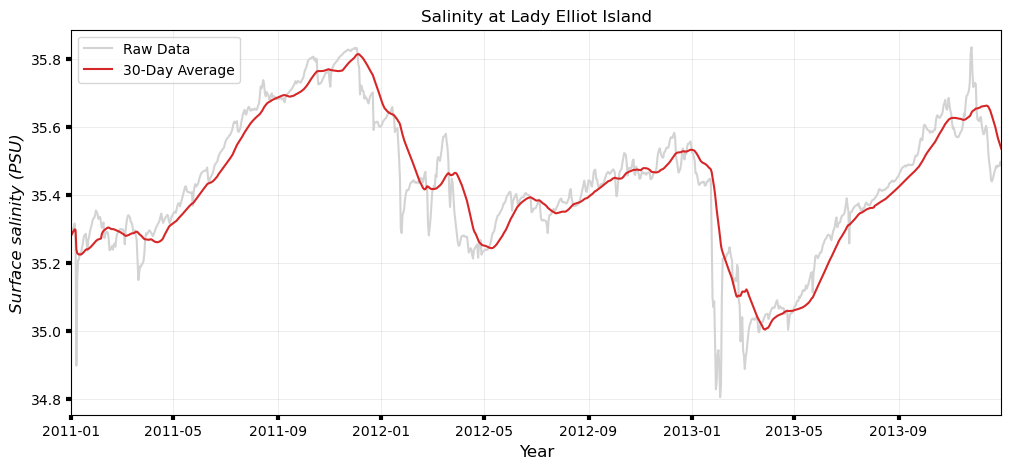

In [12]:
### SALINITY
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.salinity, color="lightgrey")
ax1.plot(
    timeseries.date,
    timeseries.salinity_roll,
    color="tab:red"
)
ax1.legend(
    labels=["Raw Data", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Surface salinity (PSU)", style="italic", fontsize=12)
print("Min surface salinity: {:0.3f} PSU".format(min(timeseries.salinity)))
print("Max surface salinity: {:0.3f} PSU".format(max(timeseries.salinity)))
print("Mean surface salinity: {:0.3f} PSU".format(np.mean(timeseries.salinity)))
print("Median surface salinity: {:0.3f} PSU".format(np.median(timeseries.salinity)))
print("SD surface salinity: {:0.3f} PSU".format(np.std(timeseries.salinity)))
print("95th percentile surface salinity: {:0.3f} PSU".format(np.percentile(timeseries.salinity, 95)))

ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.title("Salinity at Lady Elliot Island")
plot_path = os.path.join(timeseries_folder, "LE_salinity_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

*u current*

Min surface u: -0.497 m/s
Max surface u: 0.344 m/s
Mean surface u: -0.040 m/s
Median surface u: -0.031 m/s
SD surface u: 0.126 m/s
95th percentile surface u: 0.148 m/s


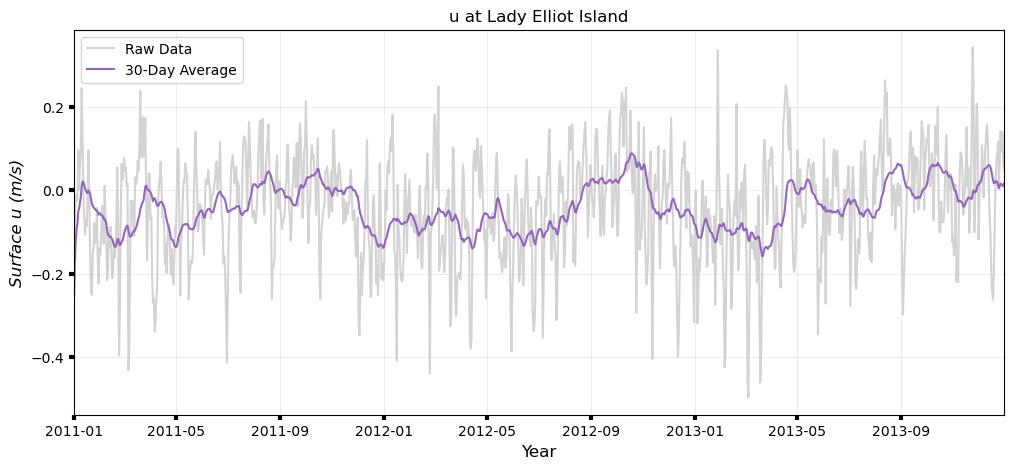

In [13]:
### u
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.u, color="lightgrey")
ax1.plot(
    timeseries.date,
    timeseries.u_roll,
    color="tab:purple"
)
ax1.legend(
    labels=["Raw Data", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Surface u (m/s)", style="italic", fontsize=12)
print("Min surface u: {:0.3f} m/s".format(min(timeseries.u)))
print("Max surface u: {:0.3f} m/s".format(max(timeseries.u)))
print("Mean surface u: {:0.3f} m/s".format(np.mean(timeseries.u)))
print("Median surface u: {:0.3f} m/s".format(np.median(timeseries.u)))
print("SD surface u: {:0.3f} m/s".format(np.std(timeseries.u)))
print("95th percentile surface u: {:0.3f} m/s".format(np.percentile(timeseries.u, 95)))

ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.title("u at Lady Elliot Island")
plot_path = os.path.join(timeseries_folder, "LE_u_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

Min surface u: -0.360 m/s
Max surface u: 0.294 m/s
Mean surface u: 0.013 m/s
Median surface u: 0.012 m/s
SD surface u: 0.079 m/s
95th percentile surface u: 0.144 m/s


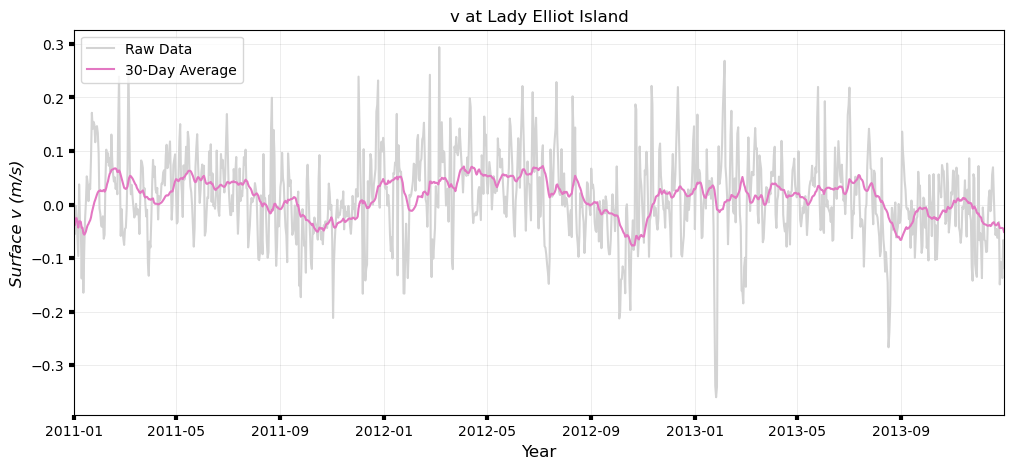

In [14]:
### v
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.v, color="lightgrey")
ax1.plot(
    timeseries.date,
    timeseries.v_roll,
    color="tab:pink"
)
ax1.legend(
    labels=["Raw Data", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Surface v (m/s)", style="italic", fontsize=12)
print("Min surface u: {:0.3f} m/s".format(min(timeseries.v)))
print("Max surface u: {:0.3f} m/s".format(max(timeseries.v)))
print("Mean surface u: {:0.3f} m/s".format(np.mean(timeseries.v)))
print("Median surface u: {:0.3f} m/s".format(np.median(timeseries.v)))
print("SD surface u: {:0.3f} m/s".format(np.std(timeseries.v)))
print("95th percentile surface u: {:0.3f} m/s".format(np.percentile(timeseries.v, 95)))

ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.title("v at Lady Elliot Island")
plot_path = os.path.join(timeseries_folder, "LE_u_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

Visualize All Variables in a Single Plot

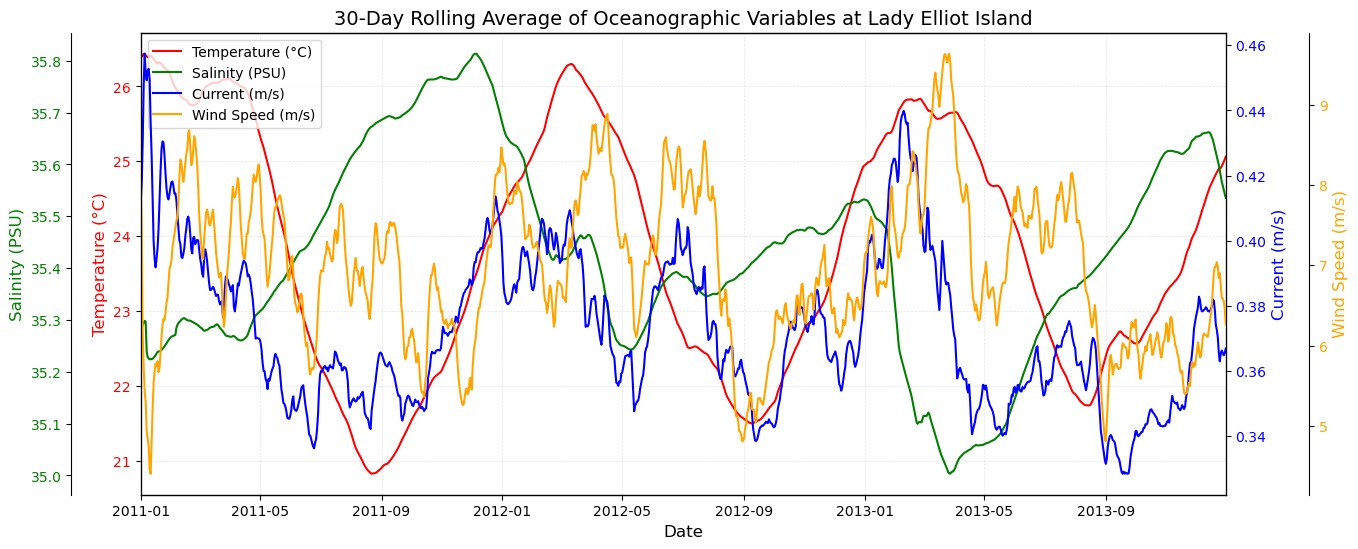

In [15]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- First axis (Temperature, left) ---
ax1.plot(timeseries.date, timeseries.temperature_roll, color="red", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="red", fontsize=12)
ax1.tick_params(axis="y", labelcolor="red")

# --- Second axis (Salinity, left but offset slightly) ---
ax2 = ax1.twinx()
ax2.spines["left"].set_position(("outward", 50))  # move slightly left
ax2.yaxis.set_label_position("left")
ax2.yaxis.set_ticks_position("left")
ax2.plot(timeseries.date, timeseries.salinity_roll, color="green", label="Salinity (PSU)")
ax2.set_ylabel("Salinity (PSU)", color="green", fontsize=12)
ax2.tick_params(axis="y", labelcolor="green")

# --- Third axis (Current, right) ---
# Mean current
ax3 = ax1.twinx()
ax3.plot(timeseries.date, timeseries.current_roll, color="blue", label="Current (m/s)")
ax3.set_ylabel("Current (m/s)", color="blue", fontsize=12)
ax3.tick_params(axis="y", labelcolor="blue")

### Summarized in mean_cur variable so I'm excluding to avoid overcrowding the plot
# # --- Third axis (Current, right) ---
# # u current
# ax3 = ax1.twinx()
# ax3.plot(timeseries.date, timeseries.u_roll, color="cyan", label="U (m/s)")

# # --- Third axis (Current, right) ---
# # v current
# ax3 = ax1.twinx()
# ax3.plot(timeseries.date, timeseries.v_roll, color="purple", label="V (m/s)")

# --- Fourth axis (Wind Speed, right and further offset) ---
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 60))
ax4.plot(timeseries.date, timeseries.wind_roll, color="orange", label="Wind Speed (m/s)")
ax4.set_ylabel("Wind Speed (m/s)", color="orange", fontsize=12)
ax4.tick_params(axis="y", labelcolor="orange")

# --- Common x-axis formatting ---
ax1.set_xlabel("Date", fontsize=12)
ax1.set_title("30-Day Rolling Average of Oceanographic Variables at Lady Elliot Island", fontsize=14)
ax1.set_xlim(timeseries.date.min(), timeseries.date.max())
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="--")

# --- Combine all legends ---
lines, labels = [], []
for ax in [ax1, ax2, ax3, ax4]:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)
ax1.legend(lines, labels, loc="upper left", fontsize=10)

# --- Save and show ---
plot_path = os.path.join(timeseries_folder, "LE_ereefs_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

# Step 4 - Compare Seasonal and Interannual Trends 

Define Seasons for Each Variable

In [16]:
# Define function "getSeason" to collect the season information for each variable ("param") 
# Inspect the "timeseries" dataframe to ensure a "param" column exists
def getSeason(param):
    if param not in timeseries.columns:
        raise KeyError(f"'{param}' not found in timeseries columns: {list(timeseries.columns)}")
    
    # -- Use "groupby" function to create a df where rows are grouped by year and month --
    # Calculate selected parameter average for each month of each year
    tdf = (
        timeseries.groupby(["year", "month"])[param]
        .mean()
        .reset_index()
    )

    # Create new reshaped dataframe with columns as months and rows as years 
    dfseason = tdf.pivot(index="year", columns="month", values=param)

    # Rename months
    dfseason = dfseason.rename(
        columns={
            1: "January",
            2: "February",
            3: "March",
            4: "April",
            5: "May",
            6: "June",
            7: "July",
            8: "August",
            9: "September",
            10: "October",
            11: "November",
            12: "December",
        }
    )

    return dfseason

# Repeat this process for each variable
Current_season = getSeason("current")
Wind_season    = getSeason("wind")
Temp_season    = getSeason("temperature")
Salt_season    = getSeason("salinity")

## **Produce Variable Heatmaps**

*Current Speed*

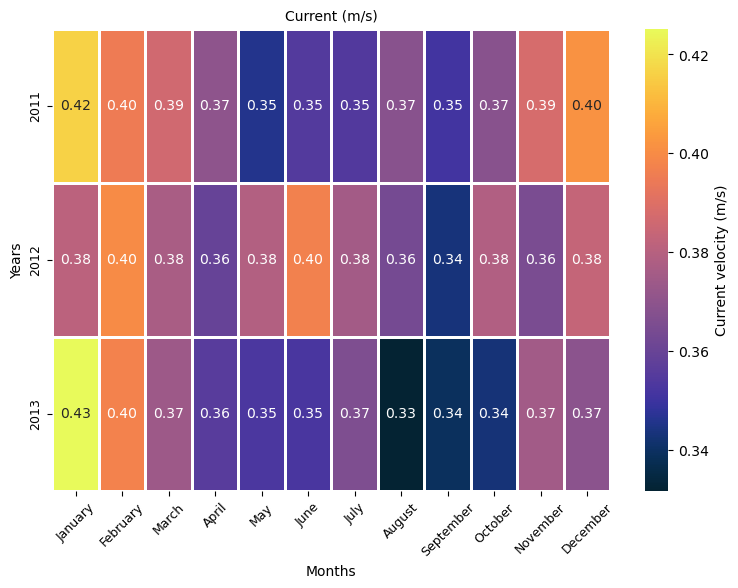

In [19]:
# Current
color = cmocean.cm.thermal
fig, ax = plt.subplots(figsize=(9, 6))

# Plot monthly average against year with colour showing value intensity
sns.heatmap(
    Current_season,
    annot=True,
    fmt=".2f",
    cmap=color,
    linewidths=1,
    cbar=True,                     
    cbar_kws={'label': 'Current velocity (m/s)'}  
)

# Stylize and label axes
ax.set_title("Current (m/s)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)

# Save and show the plot
plot_path = os.path.join(heatmaps_folder, "seasonal_current_heatmap.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

*Temperature*

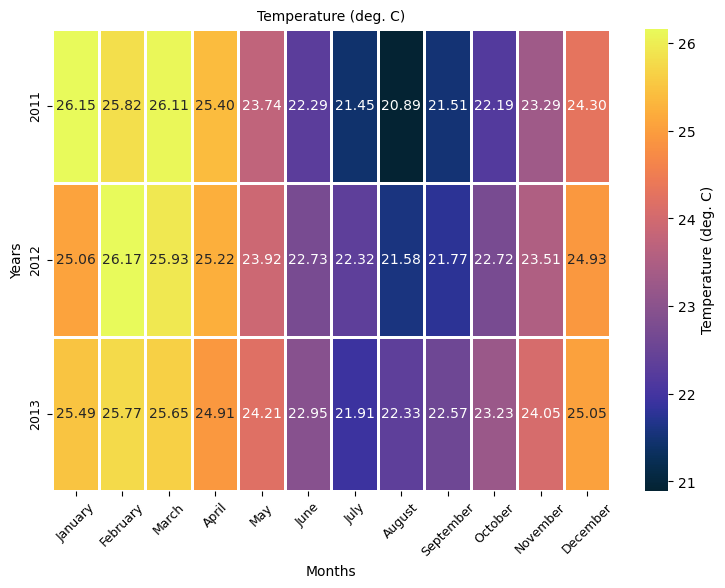

In [21]:
# Temperature
color = cmocean.cm.thermal
fig, ax = plt.subplots(figsize=(9, 6))

# Plot monthly average against year with colour showing value intensity
sns.heatmap(
    Temp_season,
    annot=True,
    fmt=".2f",
    cmap=color,
    linewidths=1,
    cbar=True,                     
    cbar_kws={'label': 'Temperature (deg. C)'}  
)

# Stylize and label axes
ax.set_title("Temperature (deg. C)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)

# Save and show the plot
plot_path = os.path.join(heatmaps_folder, "seasonal_temperature_heatmap.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

*Salinity*

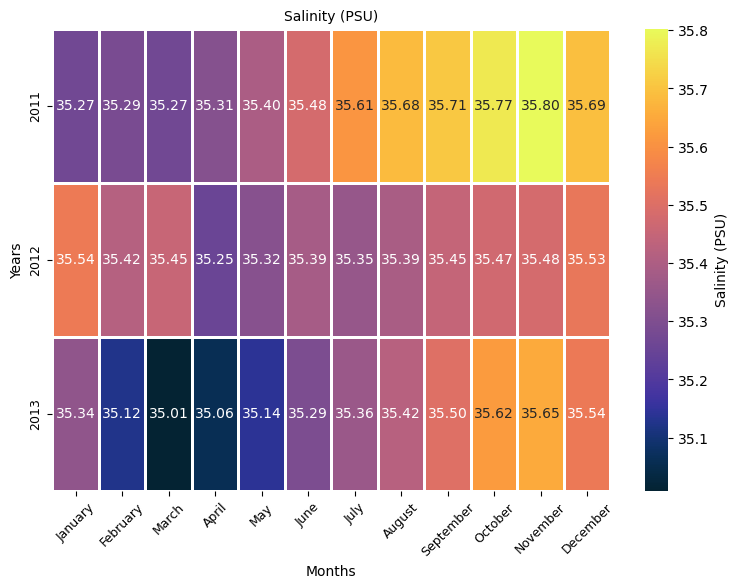

In [22]:
# Salinity
color = cmocean.cm.thermal
fig, ax = plt.subplots(figsize=(9, 6))

# Plot monthly average against year with colour showing value intensity
sns.heatmap(
    Salt_season,
    annot=True,
    fmt=".2f",
    cmap=color,
    linewidths=1,
    cbar=True,                     
    cbar_kws={'label': 'Salinity (PSU)'}  
)

# Stylize and label axes
ax.set_title("Salinity (PSU)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)

# Save and show the plot
plot_path = os.path.join(heatmaps_folder, "seasonal_salinity_heatmap.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

*Wind*

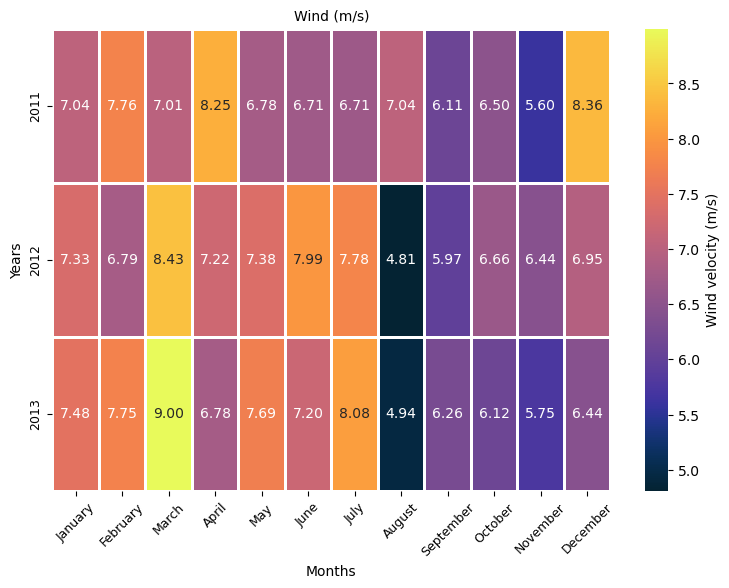

In [23]:
# Wind
color = cmocean.cm.thermal
fig, ax = plt.subplots(figsize=(9, 6))

# Plot monthly average against year with colour showing value intensity
sns.heatmap(
    Wind_season,
    annot=True,
    fmt=".2f",
    cmap=color,
    linewidths=1,
    cbar=True,                     
    cbar_kws={'label': 'Wind velocity (m/s)'}  
)

# Stylize and label axes
ax.set_title("Wind (m/s)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)

# Save and show the plot
plot_path = os.path.join(heatmaps_folder, "seasonal_wind_heatmap.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

## **Plot Variable Distributions**

Visualize monthly variation for each variable across the selected timeframe 

*Wind*

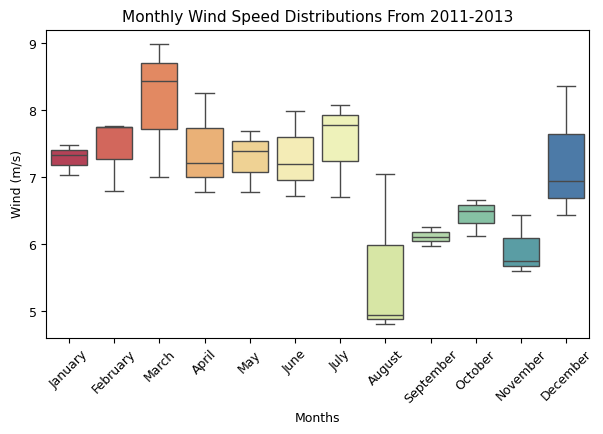

In [21]:
# Wind
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=Wind_season, palette="Spectral")
ax.set_title("Monthly Wind Speed Distributions From 2011-2013", fontsize=11)
ax.set_ylabel("Wind (m/s)", fontsize=9)
ax.set_xlabel("Months", fontsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plot_path = os.path.join(distributions_folder, "monthly_wind_distribution.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

Calculate Range of Values Each Month

In [22]:
# Define wind_range as the max - min of values in each month of the Wind_season dataframe
wind_range = Wind_season.max() - Wind_season.min()
print(wind_range)
print(wind_range.mean())

month
January      0.448148
February     0.974154
March        1.990221
April        1.470594
May          0.909797
June         1.277936
July         1.371455
August       2.229414
September    0.286738
October      0.538622
November     0.839374
December     1.914346
dtype: float64
1.187566724545505


*Salinity*

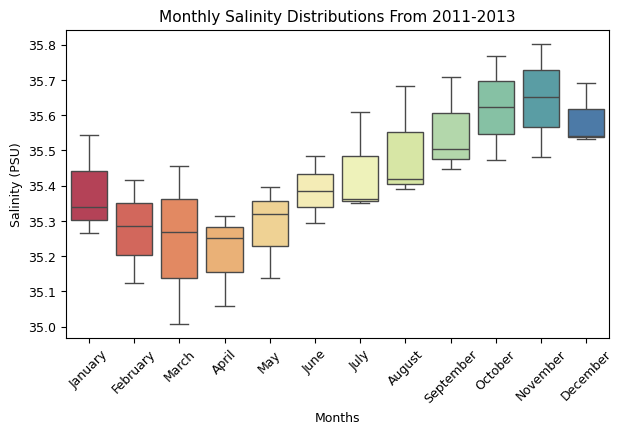

In [23]:
# Salinity
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=Salt_season, palette="Spectral")
ax.set_title("Monthly Salinity Distributions From 2011-2013", fontsize=11)
ax.set_ylabel("Salinity (PSU)", fontsize=9)
ax.set_xlabel("Months", fontsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plot_path = os.path.join(distributions_folder, "monthly_salinity_distribution.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

In [24]:
salt_range = Salt_season.max() - Salt_season.min()
print(salt_range)
print(salt_range.mean())

month
January      0.275869
February     0.292815
March        0.445779
April        0.255104
May          0.255812
June         0.189494
July         0.257719
August       0.292735
September    0.258543
October      0.295774
November     0.321500
December     0.158413
dtype: float64
0.27496303887807433


*Current*

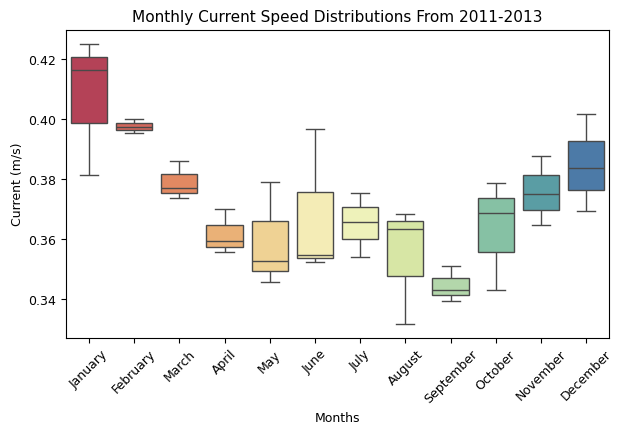

In [25]:
# Current
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=Current_season, palette="Spectral")
ax.set_title("Monthly Current Speed Distributions From 2011-2013", fontsize=11)
ax.set_ylabel("Current (m/s)", fontsize=9)
ax.set_xlabel("Months", fontsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plot_path = os.path.join(distributions_folder, "monthly_current_distribution.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

In [26]:
current_range = Current_season.max() - Current_season.min()
print(current_range)
print(current_range.mean())

month
January      0.043972
February     0.004758
March        0.012373
April        0.014188
May          0.033333
June         0.044380
July         0.021320
August       0.036749
September    0.011620
October      0.035937
November     0.023111
December     0.032570
dtype: float64
0.026192566552940208


*Temperature*

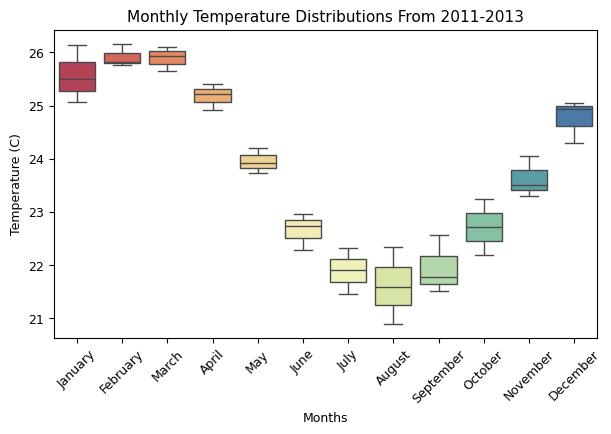

In [27]:
# Temperature
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=Temp_season, palette="Spectral")
ax.set_title("Monthly Temperature Distributions From 2011-2013", fontsize=11)
ax.set_ylabel("Temperature (C)", fontsize=9)
ax.set_xlabel("Months", fontsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plot_path = os.path.join(distributions_folder, "monthly_temperature_distribution.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

In [28]:
temp_range = Temp_season.max() - Temp_season.min()
print(temp_range)
print(temp_range.mean())

month
January      1.088808
February     0.392832
March        0.462914
April        0.491345
May          0.469646
June         0.662437
July         0.868530
August       1.438252
September    1.062494
October      1.042420
November     0.762360
December     0.742054
dtype: float64
0.790341078704954


# Step 5 - Calculate Monthly Statistics

Calculate number of standard deviations each variable varies from the monthly mean

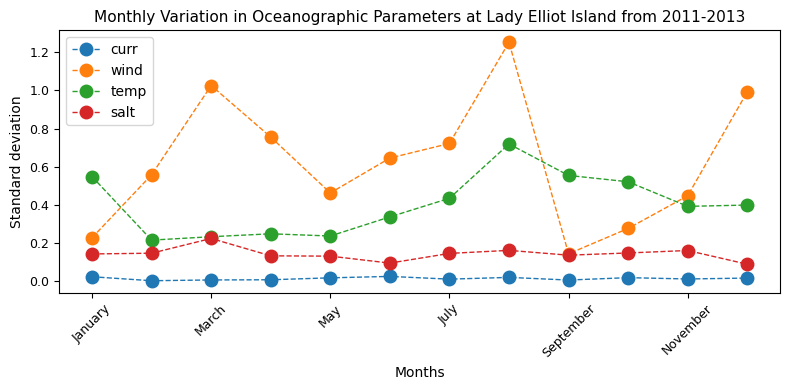

In [29]:
curr_sd = Current_season.std(axis=0)
wind_sd = Wind_season.std(axis=0)
temp_sd = Temp_season.std(axis=0)
salt_sd = Salt_season.std(axis=0)

# Make figure
fig, ax = plt.subplots(figsize=(8, 4))

curr_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='curr')
wind_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='wind')
temp_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='temp')
salt_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='salt')

ax.set_title("Monthly Variation in Oceanographic Parameters at Lady Elliot Island from 2011-2013",fontsize=11)
ax.set_ylabel("Standard deviation", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.legend() #loc='upper right', bbox_to_anchor=(0.91, 0.91))
plt.tight_layout()
plt.show()

Extract Specific Information

*Monthly standard deviation values*

In [30]:
# Wind speed
print(wind_sd)

month
January      0.227712
February     0.557844
March        1.025646
April        0.755398
May          0.462557
June         0.645493
July         0.721845
August       1.252546
September    0.143498
October      0.276444
November     0.447818
December     0.992209
dtype: float64


*Average annual standard deviation value*

In [31]:
# Current speed
curr_sd.mean()

np.float64(0.01375158659975851)

Calculate Annual Trend and Slope

In [32]:
## CURRENT
# Convert multidimensional dataframe to 1D timeseries
curr_stack = Current_season.stack()

# Perform Seasonal Mann-Kendall which calculates annual trends accounting seasonal cycles
curr_trend = mk.seasonal_test(curr_stack, period=12)
print(" ")
print("Change in yearly current trend accounting for seasonality:")

# 'trend' indicates whether the variable has an upward, downward, or no trend (excluding seasonal patterns)
print("    +           trend: ", curr_trend.trend)

# 'slope' tells us the annual rate of change (measured in each variable's units)
print("    +    slope (m/s /y): ",str(round(curr_trend.slope * 100.0, 2)))

## WIND
wind_stack = Wind_season.stack()
wind_trend = mk.seasonal_test(wind_stack, period=12)
print(" ")
print("Change in yearly wind trend accounting for seasonality:")
print("    +           trend: ", wind_trend.trend)
print("    +    slope (m/s /y): ",str(round(wind_trend.slope * 100.0, 2)))

## TEMPERATURE
temp_stack = Temp_season.stack()
temp_trend = mk.seasonal_test(temp_stack, period=12)
print(" ")
print("Change in yearly temperature trend accounting for seasonality:")
print("    +           trend: ", temp_trend.trend)
print("    +    slope (deg. C /y): ",str(round(temp_trend.slope, 2)))

## SALINITY
salt_stack = Salt_season.stack()
salt_trend = mk.seasonal_test(salt_stack, period=12)
print(" ")
print("Change in yearly salinity trend accounting for seasonality:")
print("    +           trend: ", salt_trend.trend)
print("    +    slope (PSU /y): ",str(round(salt_trend.slope, 2)))

 
Change in yearly current trend accounting for seasonality:
    +           trend:  no trend
    +    slope (m/s /y):  -0.6
 
Change in yearly wind trend accounting for seasonality:
    +           trend:  no trend
    +    slope (m/s /y):  13.96
 
Change in yearly temperature trend accounting for seasonality:
    +           trend:  no trend
    +    slope (deg. C /y):  0.27
 
Change in yearly salinity trend accounting for seasonality:
    +           trend:  decreasing
    +    slope (PSU /y):  -0.1
